In [ ]:
Ex_比價MO&PC

# 比價爬蟲

這邊會分成三部分:
* A網站爬蟲
* B網站爬蟲
* 顯示資料的程式
A網站的部分會是momo購物網, B網站是PChome 24h購物網, 而要比價的商品是iPhone 7 Plus 128G. 在搜集一定量資料後, 可以透過圖表觀察價格的變化.

### momo購物網爬蟲
這邊是去爬momo購物網的行動版網頁, 要注意的地方是你必須附上User-Agent才可以.

In [4]:
print ('%s %s'%('Python', 'Tab'))

Python Tab


In [10]:
import urllib.parse
import requests
import time
import json
import os
from bs4 import BeautifulSoup


STORE = 'momo'
MOMO_MOBILE_URL = 'http://m.momoshop.com.tw/'
MOMO_QUERY_URL = MOMO_MOBILE_URL + 'mosearch/%s.html' #%s，表示格式化一個對象為字符
USER_AGENT_VALUE = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'


def get_web_content(query):
    encoded_query = urllib.parse.quote(query) #quote():對URL進行編碼(參見Ch00_URL)，也就是解析我們要查詢的關鍵字
    query_url = MOMO_QUERY_URL % encoded_query  #搭配前面%s格式化
    headers = {'User-Agent': USER_AGENT_VALUE}
    resp = requests.get(query_url, headers=headers)
    if not resp:
        return []
    resp.encoding = 'UTF-8'
    return BeautifulSoup(resp.text, 'html.parser')


def search_momo(query):
    dom = get_web_content(query)
    if dom:
        items = []
        for element in dom.find('article', 'prdListArea').ul.find_all('li'):
            item_name = element.find('p', 'prdName').text
            item_price = element.find('b', 'price').text.replace(',', '').replace('$', '')
            if not item_price:
                continue
            item_price = int(item_price)
            item_url = MOMO_MOBILE_URL + element.find('a')['href']
            item_img_url = element.a.img['src']

            item = {
                'name': item_name,
                'price': item_price,
                'url': item_url,
                'img_url': item_img_url
            }

            items.append(item)
        return items


def save_search_result(data):
    with open(os.path.join('json', data['date'] + '-%s.json' % STORE), 'w', encoding='UTF-8') as file:
        #函數 os.path.join()：將多個路徑組合後返回
        json.dump(data, file, indent=2, ensure_ascii=False)
        #'json\\02-21-momo.json'


def main():
    query_str = 'iPhone 11 Plus 128G'
    items = search_momo(query_str)
    today = time.strftime('%m-%d')
    print('Search item \'%s\' from %s...' % (query_str, STORE))
    print('Search %d records on %s' % (len(items), today))
    for item in items:
        print(item)
    data = {
        'date': today,
        'store': STORE,
        'items': items
    }

    save_search_result(data)


if __name__ == '__main__':
    main()

Search item 'iPhone 11 Plus 128G' from momo...
Search 11 records on 02-25
{'name': '\r\n              【Apple 蘋果】iPhone 11 128G 6.1吋(犀牛盾耐衝殼組)\r\n            ', 'price': 27700, 'url': 'http://m.momoshop.com.tw//goods.momo?i_code=7024827&mdiv=searchEngine&oid=1_1&kw=iPhone 11 Plus 128G', 'img_url': 'https://img1.momoshop.com.tw/ecm/img/online/341/2020/01/14/144049056/2020011414404905601.png?t=20200221170650'}
{'name': '\r\n              【Apple 蘋果】iPhone 11 128G 6.1吋(Beats urBeats3耳機組)\r\n            ', 'price': 28890, 'url': 'http://m.momoshop.com.tw//goods.momo?i_code=7024794&mdiv=searchEngine&oid=1_2&kw=iPhone 11 Plus 128G', 'img_url': 'https://img2.momoshop.com.tw/ecm/img/online/341/2020/01/14/144049056/2020011414404905601.png?t=20200221170650'}
{'name': '\r\n              【PetAg 貝克】益菌多多粉PLUS 128g\r\n            ', 'price': 720, 'url': 'http://m.momoshop.com.tw//goods.momo?i_code=6444360&mdiv=searchEngine&oid=1_3&kw=iPhone 11 Plus 128G', 'img_url': 'https://img2.momoshop.com.tw/goodsim

### PChome 24h API爬蟲
PChome 24h有提供API, 所以就不用爬網頁了.

In [11]:
import html
import urllib.parse
import time
import json
import requests
import os
from requests.adapters import HTTPAdapter


STORE = 'pchome'
SESSION_TIMEOUT = 3
SESSION_MAX_RETRIES = 3
PCHOME_API_ENDPOINT = 'http://ecshweb.pchome.com.tw/search/v3.3/all/results?q=%s&sort=rnk&price=%s-%s' #all/results多這串就會找到API
PCHOME_PRODUCT_URL_PREFIX = 'http://24h.pchome.com.tw/prod/'
PCHOME_IMG_URL_PREFIX = 'http://ec1img.pchome.com.tw/'


def get_web_content(query_url): #取得網站內容
    session = requests.Session()
    session.mount(query_url, HTTPAdapter(max_retries=SESSION_MAX_RETRIES))
    try:
        # The timeout unit is second.
        resp = session.get(query_url, timeout=SESSION_TIMEOUT)
    except requests.exceptions.RequestException as e:
        print(e)
        return None
    return resp


def collect_items(raw_data):  #商品資料
    extracted_items = list()
    raw_items = raw_data['prods']
    for raw_item in raw_items:
        try:
            item = dict()
            item['name'] = html.unescape(raw_item['name'])
            item['price'] = int(raw_item['price'])
            item['describe'] = raw_item['describe']
            item['img_url'] = PCHOME_IMG_URL_PREFIX + raw_item['picB']
            item['url'] = PCHOME_PRODUCT_URL_PREFIX + raw_item['Id']
            extracted_items.append(item)
        except Exception:
            pass
    return extracted_items


def search_pchome(query, min_price, max_price):
    query = urllib.parse.quote(query)
    query_url = PCHOME_API_ENDPOINT % (query, str(min_price), str(max_price)) #字串格式化，讓輸入的"iphone 7 128g plus"進到網址理
    resp = get_web_content(query_url)
    if not resp:
        return []

    resp.encoding = 'UTF-8'
    data = resp.json()
    if data['prods'] is None:
        return []

    total_page_count = int(data['totalPage'])
    if total_page_count == 1:
        return collect_items(data)

    urls = []
    current_page = 1
    while current_page <= total_page_count:
        current_page_url = query_url + '&page=' + str(current_page)
        urls.append(current_page_url)
        current_page += 1

    items = []
    for url in urls:
        resp = get_web_content(url)
        if resp:
            resp.encoding = 'UTF-8'
            items += collect_items(resp.json())
    return items


def save_search_result(data): 
    with open(os.path.join('json', data['date'] + '-%s.json' % STORE), 'w', encoding='UTF-8') as file:
        json.dump(data, file, indent=2, ensure_ascii=False)


def main():
    query_str = 'iphone 11 plus 128G'
    min_price = 10000
    max_price = 60000
    items = search_pchome(query_str, min_price, max_price)
    today = time.strftime('%m-%d')
    print('Search item \'%s\' from %s...' % (query_str, STORE))
    print('Search %d records on %s' % (len(items), today))
    for item in items:
        print(item)
    data = {
        'date': today,
        'store': STORE,
        'items': items
    }

    save_search_result(data)


if __name__ == '__main__':
    main()

Search item 'iphone 11 plus 128G' from pchome...
Search 33 records on 02-25
{'name': 'Apple iPhone 7 Plus (128G)', 'price': 16999, 'describe': '黑l玫瑰金★熱銷補貨到Apple iPhone 7 Plus (128G)\\r\\n#支援ip67防水 #升級固態式home鍵#雙鏡頭大光圈 #立體聲輸出 \r\n‧64 位元架構的 a10 fusion晶片\r\n‧嵌入式m10動作感應協同處理器\r\n‧5.5吋multi-touch的retina hd顯示器\r\n‧支援ip67防塵防水\r\n‧1200萬畫素廣角+長焦雙鏡頭 \r\n‧2倍光學變焦+10倍數位變焦雙鏡頭\r\n‧前鏡頭升級700萬畫素\r\n‧ios11作業系統\r\n\r\n  ◤相關注意◢\r\n  ★『由於本商品為特殊3c產品，商品經連上網路(含wifi)、登入apple id或連結上itunes後，此商品即被註冊並開始計算商品保固時間，且經註冊後此商品的保固日期即開始計算，無法還原！日後需辦理退貨時，經本公司確認，若此商品已被開啟保固時間，需要另外酌收額外的費用。在您還不確定是否要辦理退貨以前，請勿將此商品連上網路，避免在不經意的情況下開始保固時間。\r\n    主張七日鑑賞期者，猶豫期""並非試用期""，所以在尚未決定是否購買前，請保持原廠完整包裝及配件與其他贈品之完整性，若退貨商品本體刮痕或損壞，原廠外盒包裝損毀或商品缺件，將在您辦理退貨時，本公司將視毀損程度索賠，因無法復原新品保固狀態之折損費用。\r\n    您確認已閱讀前述說明並同意於此頁面下單視同同意本條款，不便之處敬請見諒謝謝。』\r\n\r\n*請注意黑色為霧面金屬黑!!', 'img_url': 'http://ec1img.pchome.com.tw//items/DYAJ86A900ADDZ1/000001_1574672173.jpg', 'url': 'http://24h.pchome.com.tw/prod/DYAJ86-A900ADDZ1'}
{'name': 'Apple iPhone 7 Plus (128G)', 'price': 14990, 'descri

### 比價圖表程式
搜集了一定數量的資料後, 就可以用圖表來展示結果了.

momo
02-25 21735
pchome
02-25 16785


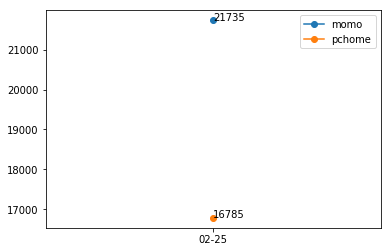

dict_keys(['02-25'])


In [22]:
import json
import os
from matplotlib import pyplot as plt


def get_avg_price(json_data): #計算該商城此商品平均價格
    sum = 0
    for item in json_data:
        sum += int(item['price'])
    return sum/len(json_data) 


def main():
    json_files = [f for f in os.listdir('json')
                  if os.path.isfile(os.path.join('json', f)) and f.endswith('.json')]

    avg_prices_momo = dict()
    avg_prices_pchome = dict()

    for json_file in json_files:
        with open(os.path.join('json', json_file), 'r', encoding='UTF-8') as file:
            data = json.load(file)
            date = data['date']
            if data['store'] == 'momo':
                avg_prices_momo[date] = get_avg_price(data['items'])
            elif data['store'] == 'pchome':
                avg_prices_pchome[date] = get_avg_price(data['items'])

    keys = avg_prices_momo.keys() #dict_keys(['02-25'])
    dates = sorted(keys) #日期分組
    print('momo')
    for date in dates: #依照不同日期去計算當日momo商品平均價格
        print(date, int(avg_prices_momo[date])) #列出[日期, 價格]，當累積多了就會變數列，用來做圖
    print('pchome')
    for date in dates: #依照不同日期去計算當日pc24商品平均價格
        print(date, int(avg_prices_pchome[date]))

    # x-axis
    x = [int(i) for i in range(len(dates))]
    plt.xticks(x, dates)  # 將 x-axis 用字串標註
    price_momo = [avg_prices_momo[d] for d in dates]  # y1-axis
    price_pchome = [avg_prices_pchome[d] for d in dates]  # y2-axis
    plt.plot(x, price_momo, marker='o', linestyle='solid')
    plt.plot(x, price_pchome, marker='o', linestyle='solid')
    plt.legend(['momo', 'pchome'])
    # specify values on ys
    for a, b in zip(x, price_momo):
        plt.text(a, b, str(int(b)))
    for a, b in zip(x, price_pchome):
        plt.text(a, b, str(int(b)))
    plt.show()


if __name__ == '__main__':
    main()